In [400]:
#installs
#!pip install xlrd
#!pip install uncertainties

In [401]:
#imports
import pandas as pd
import numpy as np
from uncertainties import unumpy as unp
from uncertainties import ufloat
from uncertainties.umath import *
import math
import scipy as sc
import matplotlib.pyplot as plt
from scipy import optimize
from numpy import arange
from numpy.ma.core import tan
from scipy.optimize import curve_fit
import csv
from scipy.stats import norm

In [402]:
#Definitionen
e = 1.6*np.float_power(10,-19)
h = 6.626*np.float_power(10,-34)
c = 3*np.float_power(10,8)

In [403]:
#methods

def add_column_with_constant(array, constant_value):
    # Get the shape of the input array
    shape = array.shape
    
    # Create a column with constant values
    constant_column = np.full((shape[0], 1), constant_value)
    
    # Append the constant column to the input array
    new_array = np.concatenate((constant_column, array), axis=1)
    
    return new_array

def sinusfunct(x, a, b, phi, c):
    return (a*np.sin(b*x+phi) +c)

def logreg(x, a, b, c):
  return a/(1+b*np.exp(c*x))

def quadradic(x, a, b, c):
  return a*np.power(x,2) + b*x + c

def line(x, a, b):
  return a*x + b

def daten_fitten(funct, x_data, y_data, genauigkeit, p): #Step4/5
    #fiten
    pars, cov = curve_fit(f=funct, xdata=x_data, ydata=y_data, p0=p, bounds=[-np.inf, np.inf], maxfev=500000)
    # Get the standard deviations of the parameters (square roots of the diagonal of the covariance)
    stdevs = np.sqrt(np.diag(cov))
    print('Fitparameter')
    print(pars)
    print('zugehörige Uncertainty')
    print(stdevs)
    #datensets
    xfit = np.linspace(min(x_data), max(x_data), genauigkeit)
    yfit = funct(xfit, *pars)
    return pars, stdevs, xfit, yfit

def filter_array(array, filtervalue, index):
    # Get the second column of the input array
    second_column = array[:, index]
    
    # Find the indices where the values are greater than 10
    indices = np.where(second_column > filtervalue)
    
    # Filter the array based on the indices
    filtered_array = array[indices]
    
    return filtered_array

def filter_array_under(array, filtervalue, index):
    # Get the second column of the input array
    second_column = array[:, index]
    
    # Find the indices where the values are greater than 10
    indices = np.where(second_column < filtervalue)
    
    # Filter the array based on the indices
    filtered_array = array[indices]
    
    return filtered_array

def calculate_intersection_with_errors(x1, y1, error_x1, error_y1, x2, y2, error_x2, error_y2):
    # Calculate the slopes of the two lines
    slope1 = np.polyfit(x1, y1, 1)[0]
    slope2 = np.polyfit(x2, y2, 1)[0]

    # Calculate the intersection point
    intersection_x = (np.mean(y2) - np.mean(y1) + (slope1 * np.mean(x1)) - (slope2 * np.mean(x2))) / (slope1 - slope2)
    intersection_y = slope1 * intersection_x + np.mean(y1) - (slope1 * np.mean(x1))

    # Calculate the errors in the intersection point
    delta_slope1 = np.polyfit(x1 + error_x1, y1 + error_y1, 1)[0] - slope1
    delta_slope2 = np.polyfit(x2 + error_x2, y2 + error_y2, 1)[0] - slope2

    intersection_error_x = np.abs(intersection_x) * np.sqrt((delta_slope1 ** 2) + (delta_slope2 ** 2))
    intersection_error_y = np.abs(intersection_y) * np.sqrt((delta_slope1 ** 2) + (delta_slope2 ** 2))

    return intersection_x, intersection_y, intersection_error_x, intersection_error_y

In [404]:
#read data into dataframe
a1_rot = pd.read_excel('A1_rot.xlsx')
a1_blau = pd.read_excel('A1_blau.xlsx')
a2_rot = pd.read_excel('A2_rot.xlsx')
a2_laserdiode = pd.read_excel('A2_LaserDiode.xlsx')
a3_1 = pd.read_excel('A3_1.xlsx')
a3_2 = pd.read_excel('A3_2.xlsx')

#converte dataframe to array
a1_rot_array = a1_rot.values
a1_blau_array = a1_blau.values
a2_rot_array = a2_rot.values
a2_laserdiode_array = a2_laserdiode.values
a3_1_array = a3_1.values
a3_2_array = a3_2.values

#A1 data to uarray with uncertainties
uncertainty_array1 = np.array([0.005, 0.01])
a1_rot_uarray = unp.uarray(a1_rot_array, uncertainty_array1)
a1_blau_uarray = unp.uarray(a1_blau_array, uncertainty_array1)

#A2 data to uarray with uncertainties
split_col_index = 2
uncertainty_array2 = a2_rot_array[:, split_col_index:]
uncertainty_array3 = a2_laserdiode_array[:, split_col_index:]
uncertainty_array2 = add_column_with_constant(uncertainty_array2, 0.01)
uncertainty_array3 = add_column_with_constant(uncertainty_array3, 0.01)

a2_rot_uarray = unp.uarray(a2_rot_array[:, :split_col_index], uncertainty_array2)
a2_laserdiode_uarray = unp.uarray(a2_laserdiode_array[:, :split_col_index], uncertainty_array3)

#A3 data to uarray with uncertainties
uncertainty_array4 = np.array([0.01, 0.3, 0.005])
a3_1_uarray = unp.uarray(a3_1_array, uncertainty_array4)
a3_2_uarray = unp.uarray(a3_2_array, uncertainty_array4)


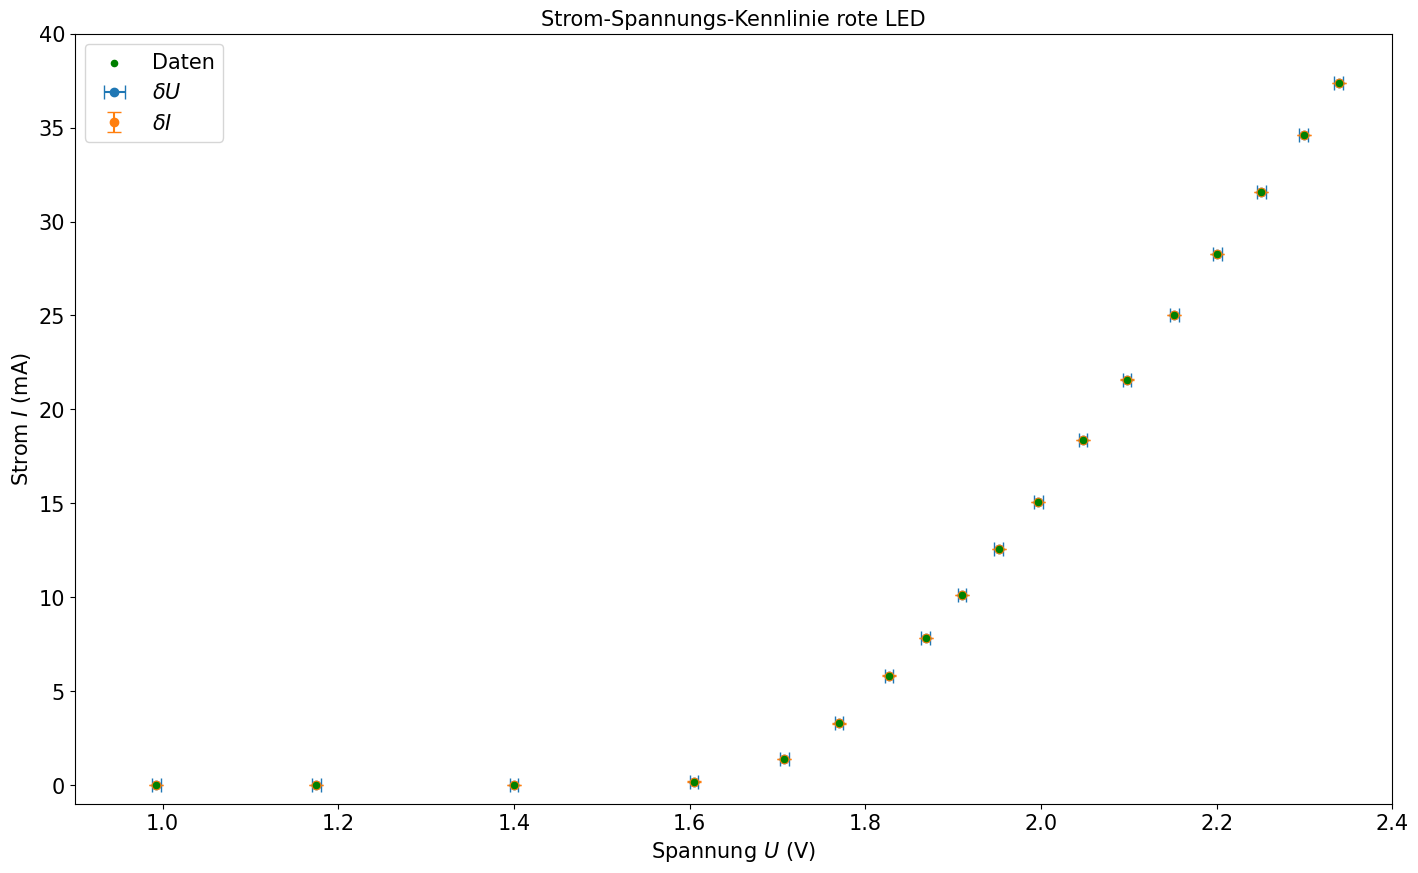

In [405]:
#Aufgabe1 rot

plt.subplots(1,1,figsize=(17, 10));

x = [float(i[0].nominal_value) for i in a1_rot_uarray]
y = [float(i[1].nominal_value) for i in a1_rot_uarray]

plt.scatter(x, y, label = 'Daten', color='green', s=20, zorder= 5)

x_error = [float(i[0].std_dev) for i in a1_rot_uarray]
y_error = [float(i[1].std_dev) for i in a1_rot_uarray]

plt.errorbar(x, y, xerr=x_error, fmt='o', capsize=5, label = r'$δU$')
plt.errorbar(x, y, yerr=y_error, fmt='o', capsize=5, label = r'$δI$')

# Add axis labels and a title
plt.xlabel(r'Spannung $U$ (V)', fontsize=15)
plt.ylabel(r'Strom $I$ (mA)', fontsize=15)
plt.title('Strom-Spannungs-Kennlinie rote LED', fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

# Display the plot
plt.legend(loc = 'upper left', fontsize=15)
plt.axis([0.9, 2.4, -1, 40]) #Achsenanpassung
plt.show()

63.85+/-0.23
-112.2+/-1.0
Schnittpunkt mit x-Achse: 1.757+/-0.018


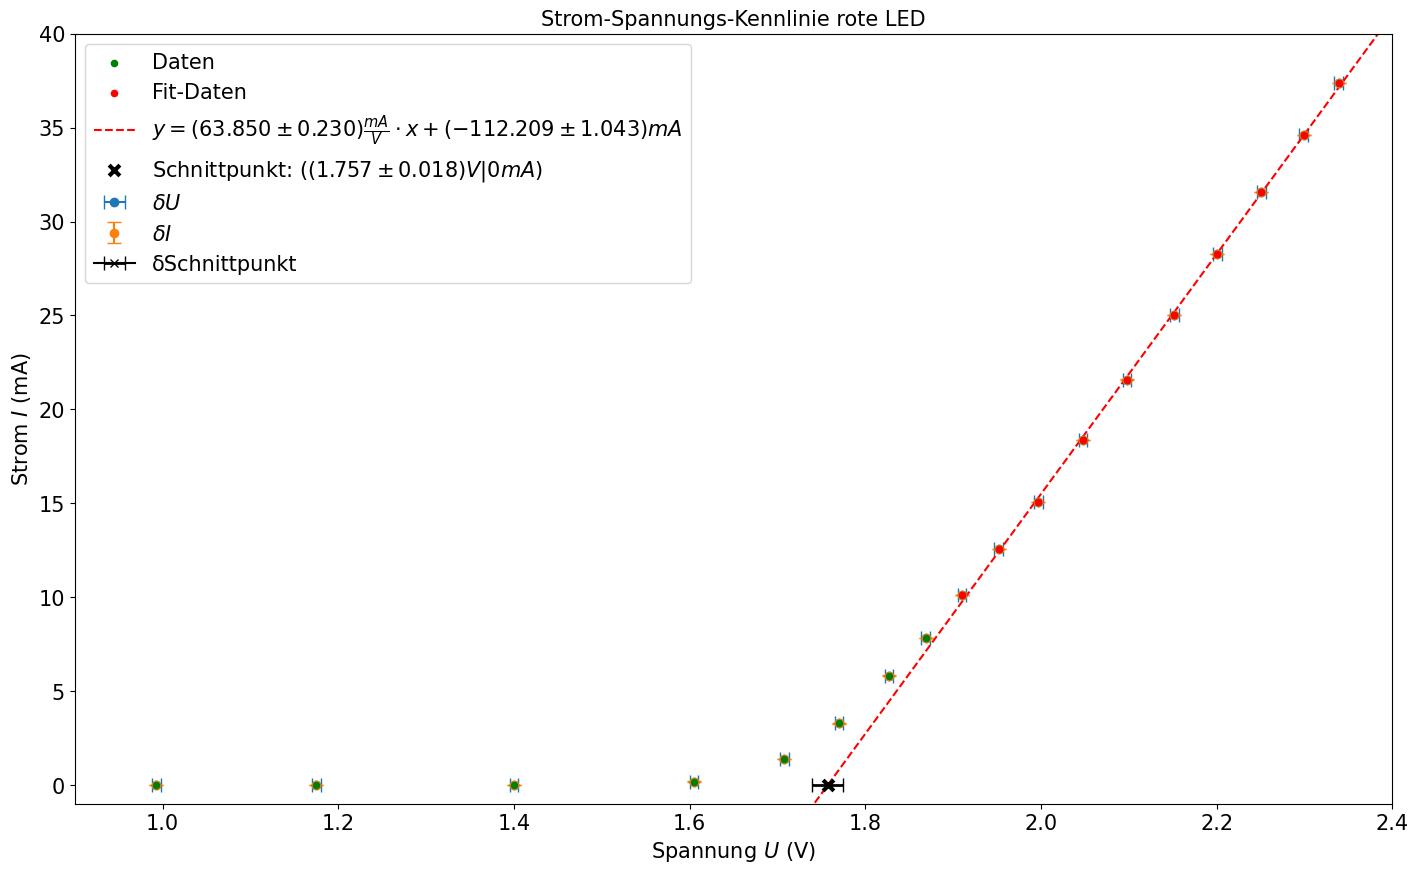

In [406]:
#Aufgabe1 rot

filtered_array = filter_array(a1_rot_uarray, 10, 1)
x1 = [float(i[0].nominal_value) for i in filtered_array]
y1 = [float(i[1].nominal_value) for i in filtered_array]

plt.subplots(1,1,figsize=(17, 10));

x = [float(i[0].nominal_value) for i in a1_rot_uarray]
y = [float(i[1].nominal_value) for i in a1_rot_uarray]

plt.scatter(x, y, label = 'Daten', color='green', s=20, zorder= 5)
plt.scatter(x1, y1, label = 'Fit-Daten', color='red', s=20, zorder= 6)

x_error = [float(i[0].std_dev) for i in a1_rot_uarray]
y_error = [float(i[1].std_dev) for i in a1_rot_uarray]

plt.errorbar(x, y, xerr=x_error, fmt='o', capsize=5, label = r'$δU$')
plt.errorbar(x, y, yerr=y_error, fmt='o', capsize=5, label = r'$δI$')

popt, pcov = sc.optimize.curve_fit(line, x1, y1)
a, b = popt
x_line = arange(-10, 10)
y_line = line(x_line, a, b)
perr = np.diag(pcov)
steigung_rot = ufloat(popt[0], pcov[0][0])
Schnitt_rot = ufloat(popt[1], pcov[1][1])

plt.plot(x_line, y_line, '--', color='red', label = r'$y = (%.3f \pm %.3f) \frac{mA}{V} \cdot x + (%.3f \pm %.3f) mA$'%(steigung_rot.nominal_value, steigung_rot.std_dev, Schnitt_rot.nominal_value, Schnitt_rot.std_dev))
print(steigung_rot)
print(Schnitt_rot)
xSchnitt = -(Schnitt_rot/steigung_rot)
print('Schnittpunkt mit x-Achse:', xSchnitt)

plt.scatter(xSchnitt.nominal_value, 0, color='black', marker='x', s=60, zorder= 7, linewidth=3, label = r'Schnittpunkt: $((%.3f \pm %.3f) V|%s mA)$' %(xSchnitt.nominal_value,xSchnitt.std_dev, 0))
plt.errorbar(xSchnitt.nominal_value, 0, xerr=xSchnitt.std_dev, marker='x', capsize=5, label = r'δSchnittpunkt', color='black', zorder= 6, elinewidth=2,)

# Add axis labels and a title
plt.xlabel(r'Spannung $U$ (V)', fontsize=15)
plt.ylabel(r'Strom $I$ (mA)', fontsize=15)
plt.title('Strom-Spannungs-Kennlinie rote LED', fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

# Display the plot
plt.legend(loc = 'upper left', fontsize=15)
plt.axis([0.9, 2.4, -1, 40]) #Achsenanpassung
plt.show()

In [407]:
#Aufgabe 1 Rechnung rot
print(xSchnitt)
Frequenz_Licht_rot = xSchnitt*e/h
Wellenlänge_Licht_rot = h*c/(xSchnitt * e)
print(Frequenz_Licht_rot)
print(Wellenlänge_Licht_rot)

1.757+/-0.018
(4.24+/-0.04)e+14
(7.07+/-0.07)e-07


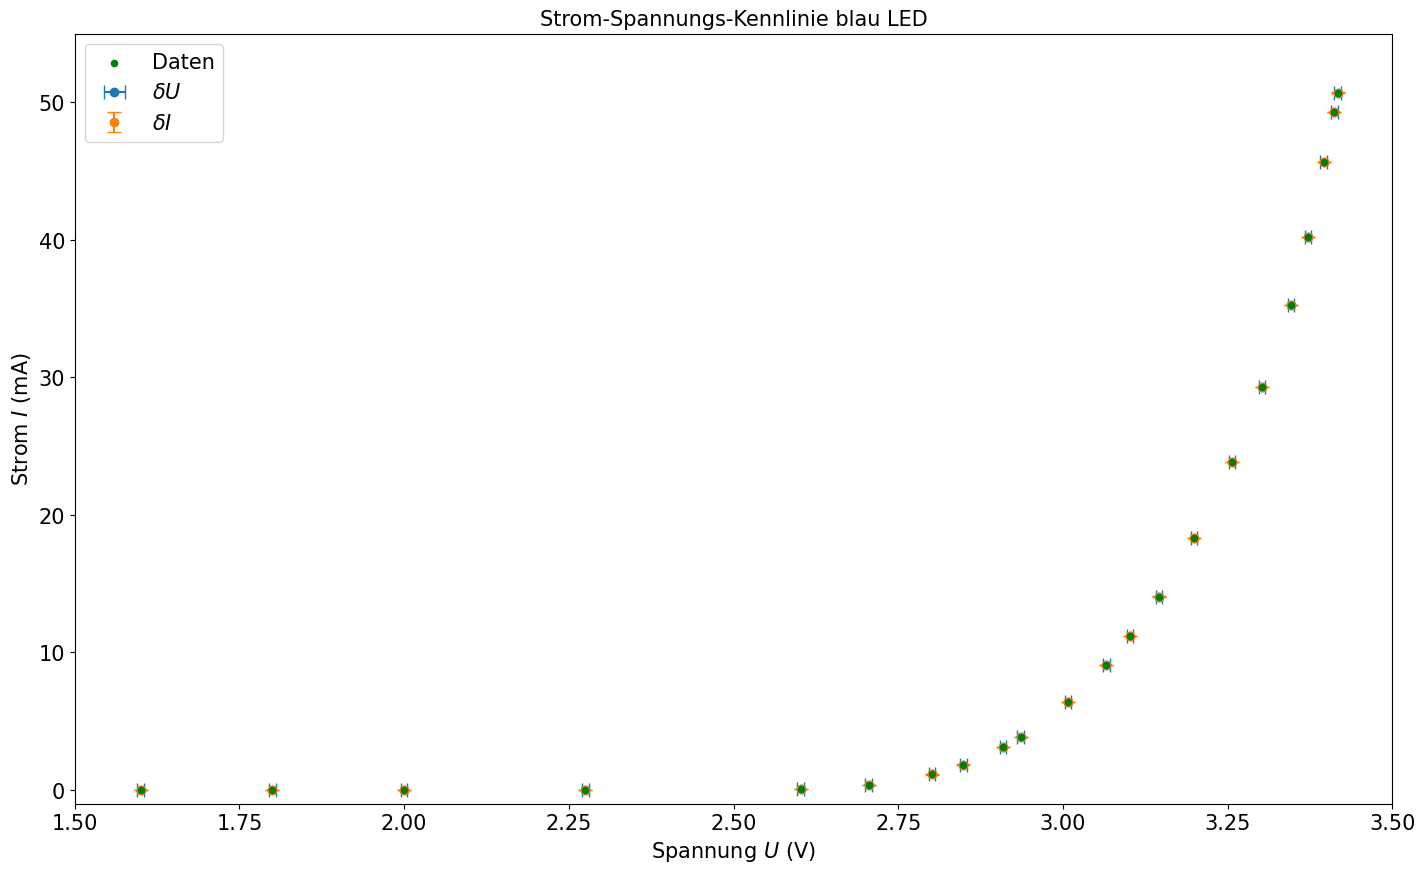

In [408]:
#Aufgabe1 blau

plt.subplots(1,1,figsize=(17, 10));

x = [float(i[0].nominal_value) for i in a1_blau_uarray]
y = [float(i[1].nominal_value) for i in a1_blau_uarray]

plt.scatter(x, y, label = 'Daten', color='green', s=20, zorder= 5)

x_error = [float(i[0].std_dev) for i in a1_blau_uarray]
y_error = [float(i[1].std_dev) for i in a1_blau_uarray]

plt.errorbar(x, y, xerr=x_error, fmt='o', capsize=5, label = r'$δU$')
plt.errorbar(x, y, yerr=y_error, fmt='o', capsize=5, label = r'$δI$')

# Add axis labels and a title
plt.xlabel(r'Spannung $U$ (V)', fontsize=15)
plt.ylabel(r'Strom $I$ (mA)', fontsize=15)
plt.title('Strom-Spannungs-Kennlinie blau LED', fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

# Display the plot
plt.legend(loc = 'upper left', fontsize=15)
plt.axis([1.5, 3.5, -1, 55]) #Achsenanpassung
plt.show()

231+/-17
(-7.4+/-2.0)e+02
Schnittpunkt mit x-Achse: 3.2+/-0.9


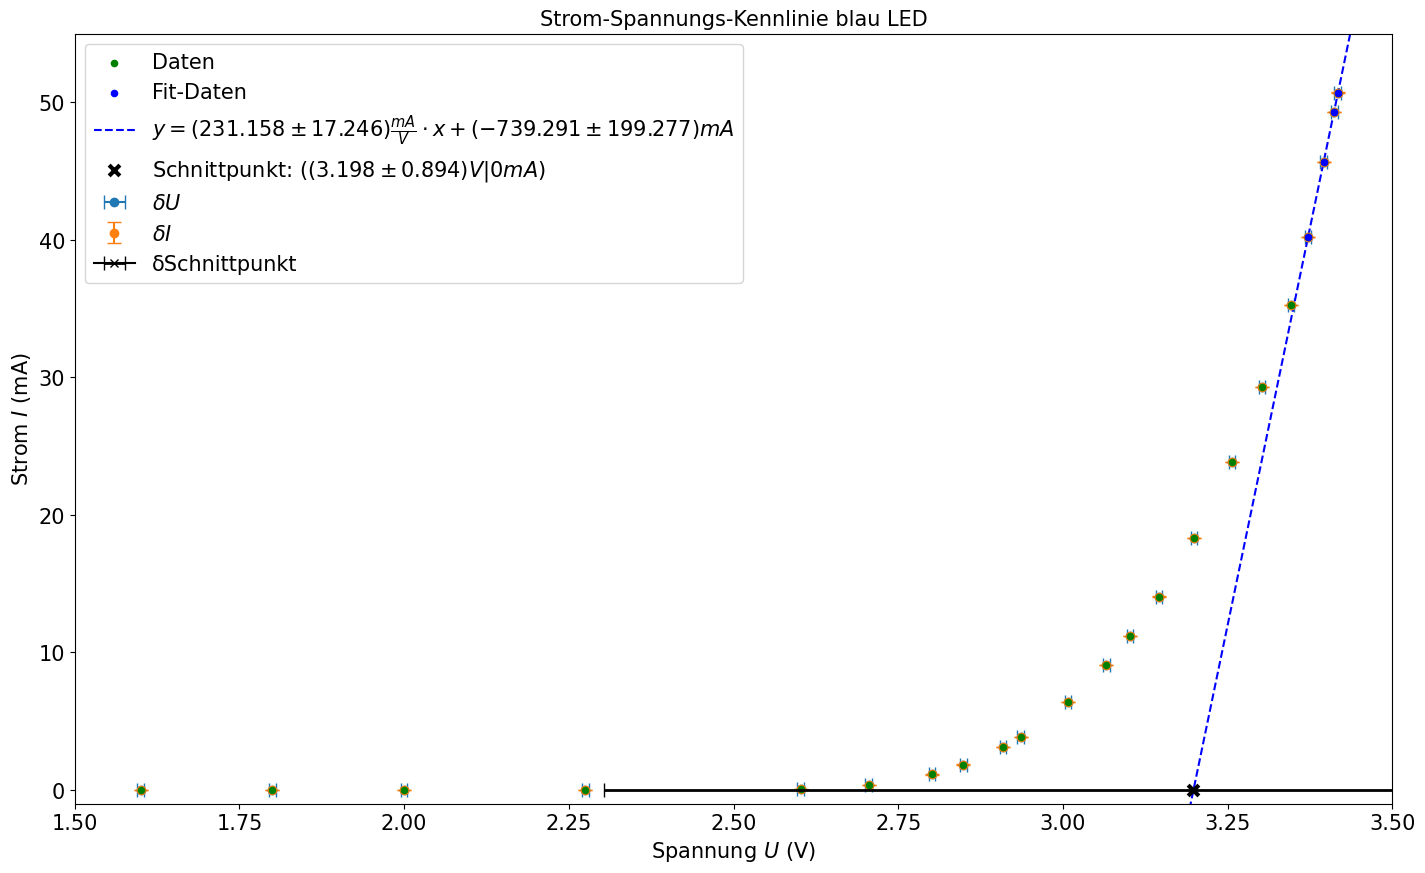

In [409]:
#Aufgabe1 blau

filtered_array = filter_array(a1_blau_uarray, 40, 1)
x1 = [float(i[0].nominal_value) for i in filtered_array]
y1 = [float(i[1].nominal_value) for i in filtered_array]

plt.subplots(1,1,figsize=(17, 10));

x = [float(i[0].nominal_value) for i in a1_blau_uarray]
y = [float(i[1].nominal_value) for i in a1_blau_uarray]

plt.scatter(x, y, label = 'Daten', color='green', s=20, zorder= 5)
plt.scatter(x1, y1, label = 'Fit-Daten', color='blue', s=20, zorder= 6)

x_error = [float(i[0].std_dev) for i in a1_blau_uarray]
y_error = [float(i[1].std_dev) for i in a1_blau_uarray]

plt.errorbar(x, y, xerr=x_error, fmt='o', capsize=5, label = r'$δU$')
plt.errorbar(x, y, yerr=y_error, fmt='o', capsize=5, label = r'$δI$')

popt, pcov = sc.optimize.curve_fit(line, x1, y1)
a, b = popt
x_line = arange(-10, 10)
y_line = line(x_line, a, b)
perr = np.diag(pcov)
steigung = ufloat(popt[0], pcov[0][0])
Schnitt = ufloat(popt[1], pcov[1][1])

plt.plot(x_line, y_line, '--', color='blue',label = r'$y = (%.3f \pm %.3f) \frac{mA}{V} \cdot x + (%.3f \pm %.3f) mA$'%(steigung.nominal_value, steigung.std_dev, Schnitt.nominal_value, Schnitt.std_dev))
print(steigung)
print(Schnitt)
xSchnitt = -(Schnitt/steigung)
print('Schnittpunkt mit x-Achse:', xSchnitt)

plt.scatter(xSchnitt.nominal_value, 0, color='black', marker='x', s=60, zorder= 7, linewidth=3, label = r'Schnittpunkt: $((%.3f \pm %.3f) V|%s mA)$' %(xSchnitt.nominal_value,xSchnitt.std_dev, 0))
plt.errorbar(xSchnitt.nominal_value, 0, xerr=xSchnitt.std_dev, marker='x', capsize=5, label = r'δSchnittpunkt', color='black', zorder= 6, elinewidth=2,)

# Add axis labels and a title
plt.xlabel(r'Spannung $U$ (V)', fontsize=15)
plt.ylabel(r'Strom $I$ (mA)', fontsize=15)
plt.title('Strom-Spannungs-Kennlinie blau LED', fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

# Display the plot
plt.legend(loc = 'upper left', fontsize=15)
plt.axis([1.5, 3.5, -1, 55]) #Achsenanpassung
plt.show()

In [410]:
#Aufgabe 1 Rechnung blau
print(xSchnitt)
Frequenz_Licht_blau = xSchnitt*e/h
Wellenlänge_Licht_blau = h*c/(xSchnitt * e)
print(Frequenz_Licht_blau)
print(Wellenlänge_Licht_blau)


3.2+/-0.9
(7.7+/-2.2)e+14
(3.9+/-1.1)e-07


Steigung: 1.9748+/-0.0007


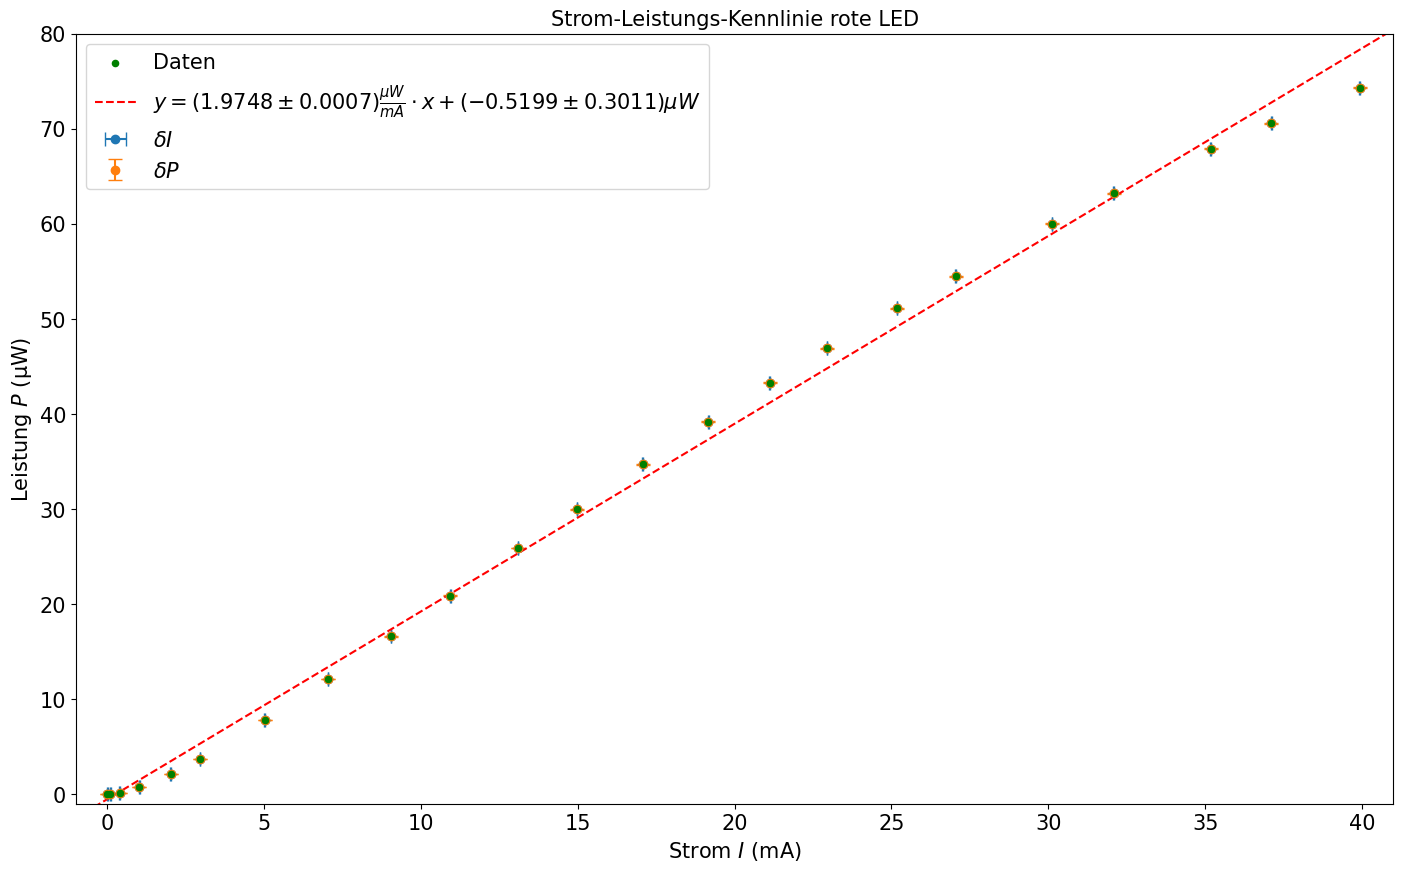

In [411]:
#Aufgabe 2 rot
df = pd.DataFrame(a2_rot_uarray)
# DataFrame in Excel-Datei exportieren
df.to_excel('outputA2_rot.xlsx', index=False)

plt.subplots(1,1,figsize=(17, 10));

x = [float(i[0].nominal_value) for i in a2_rot_uarray]
y = [float(i[1].nominal_value) for i in a2_rot_uarray]

plt.scatter(x, y, label = 'Daten', color='green', s=20, zorder= 5)

x_error = [float(i[0].std_dev) for i in a2_rot_uarray]
y_error = [float(i[1].std_dev) for i in a2_rot_uarray]

plt.errorbar(x, y, xerr=x_error, fmt='o', capsize=5, label = r'$δI$')
plt.errorbar(x, y, yerr=y_error, fmt='o', capsize=5, label = r'$δP$')

popt, pcov = sc.optimize.curve_fit(line, x, y)
a, b = popt
x_line = arange(-10, 100)
y_line = line(x_line, a, b)
perr = np.diag(pcov)
steigung = ufloat(popt[0], pcov[0][0])
Schnitt = ufloat(popt[1], pcov[1][1])

plt.plot(x_line, y_line, '--', color='red', label = r'$y = (%.4f \pm %.4f) \frac{µW}{mA} \cdot x + (%.4f \pm %.4f) µW$'%(steigung.nominal_value, steigung.std_dev, Schnitt.nominal_value, Schnitt.std_dev))
print('Steigung:', steigung)


# Add axis labels and a title
plt.xlabel(r'Strom $I$ (mA)', fontsize=15)
plt.ylabel(r'Leistung $P$ (µW)', fontsize=15)
plt.title('Strom-Leistungs-Kennlinie rote LED', fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

# Display the plot
plt.legend(loc = 'upper left', fontsize=15)
plt.axis([-1, 41, -1, 80]) #Achsenanpassung
plt.show()

In [412]:
#Aufgabe 2 Rechnung rot
Effizienz = steigung*np.float_power(10,-3)*e/(h*Frequenz_Licht_rot)
print(a2_rot_uarray[len(a2_rot_uarray)-1])
Spannung_max = (a2_rot_uarray[len(a2_rot_uarray)-1, 0] - Schnitt_rot)/ steigung_rot
Konversions_Eff = a2_rot_uarray[len(a2_rot_uarray)-1, 1]*np.float_power(10,-3)/ (Spannung_max*a2_rot_uarray[len(a2_rot_uarray)-1, 0])
print('Effizienz:',Effizienz)
print('Konversions Effizienz:', Konversions_Eff)

[39.92+/-0.01 74.3+/-0.05]
Effizienz: 0.001124+/-0.000011
Konversions Effizienz: 0.000781+/-0.000006


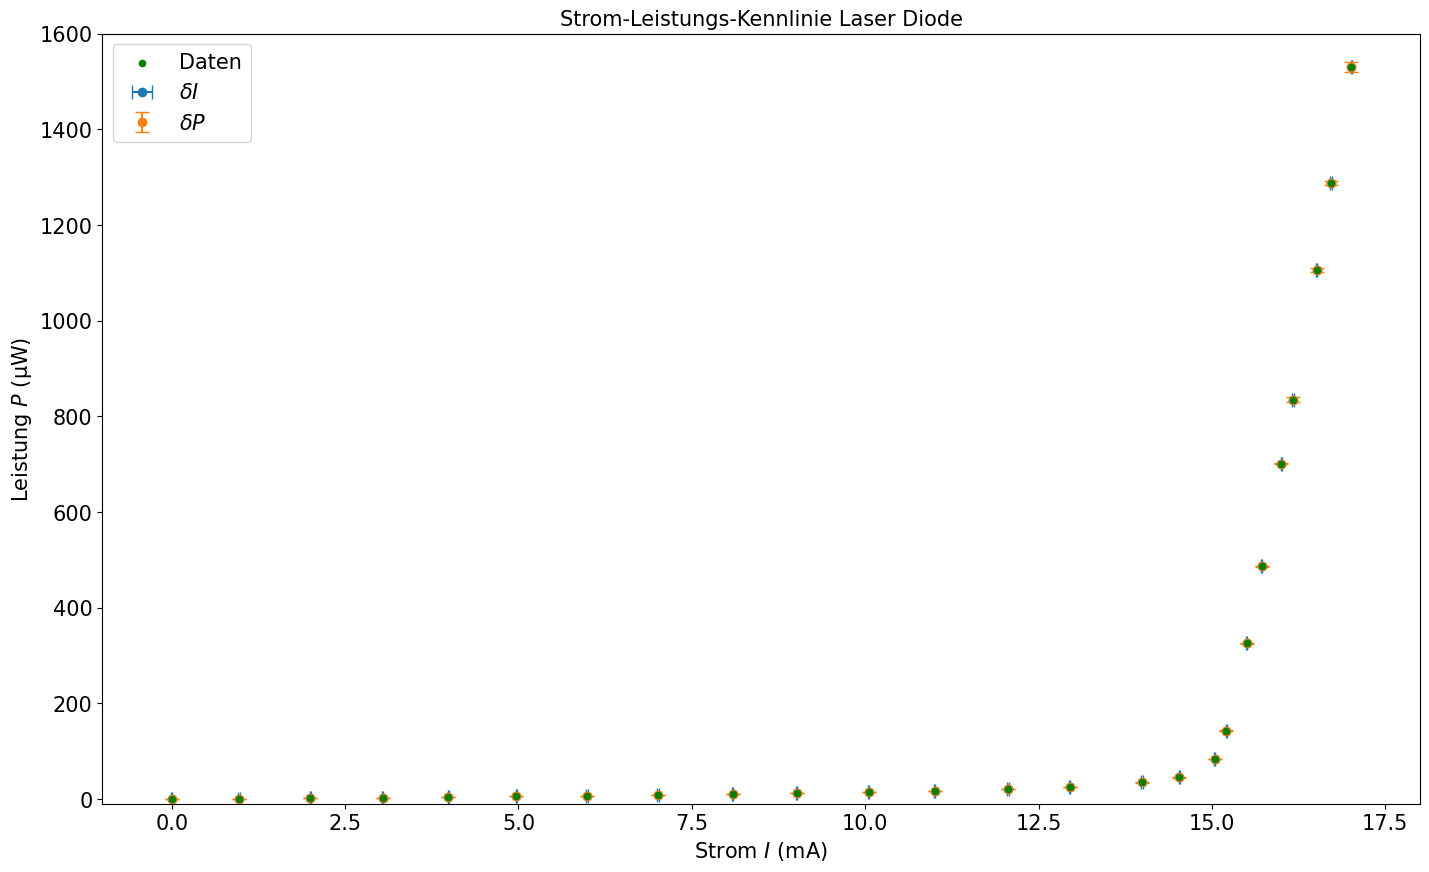

In [413]:
#Aufgabe 2 LaserDiode
df = pd.DataFrame(a2_laserdiode_uarray)
# DataFrame in Excel-Datei exportieren
df.to_excel('outputA2_Laser.xlsx', index=False)

plt.subplots(1,1,figsize=(17, 10));

x = [float(i[0].nominal_value) for i in a2_laserdiode_uarray]
y = [float(i[1].nominal_value) for i in a2_laserdiode_uarray]

plt.scatter(x, y, label = 'Daten', color='green', s=20, zorder= 5)


x_error = [float(i[0].std_dev) for i in a2_laserdiode_uarray]
y_error = [float(i[1].std_dev) for i in a2_laserdiode_uarray]

plt.errorbar(x, y, xerr=x_error, fmt='o', capsize=5, label = r'$δI$')
plt.errorbar(x, y, yerr=y_error, fmt='o', capsize=5, label = r'$δP$')

# Add axis labels and a title
plt.xlabel(r'Strom $I$ (mA)', fontsize=15)
plt.ylabel(r'Leistung $P$ (µW)', fontsize=15)
plt.title('Strom-Leistungs-Kennlinie Laser Diode', fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

# Display the plot
plt.legend(loc = 'upper left', fontsize=15)
plt.axis([-1, 18, -10, 1600]) #Achsenanpassung
plt.show()

Steigung1: 2.51+/-0.08
Steigung2: (8.0+/-0.8)e+02
[15.151] [32.48207449]


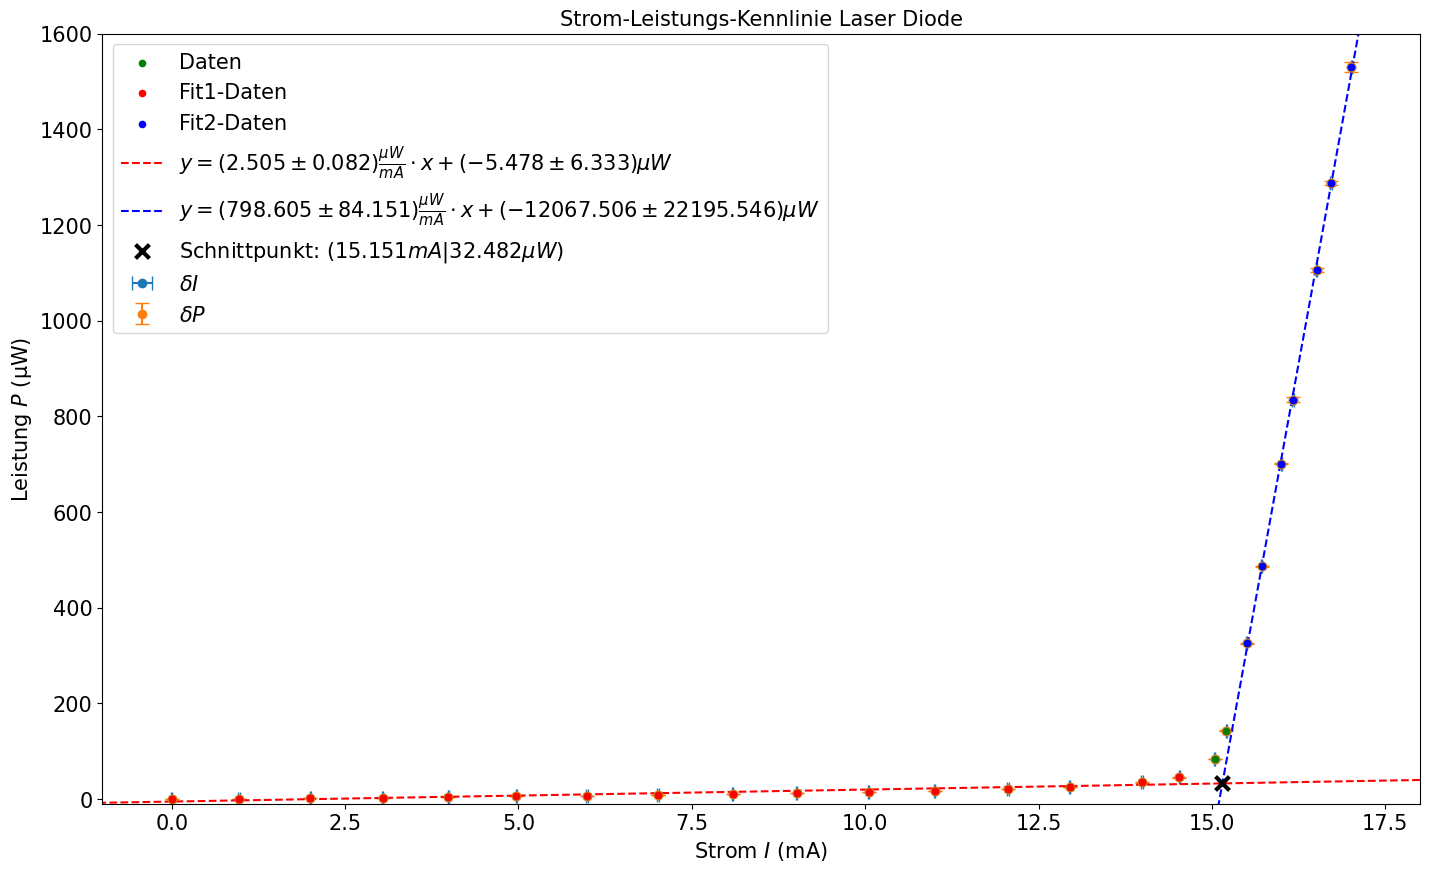

In [414]:
#Aufgabe 2 LaserDiode

filtered_array = filter_array_under(a2_laserdiode_uarray, 50, 1)
x1 = [float(i[0].nominal_value) for i in filtered_array]
y1 = [float(i[1].nominal_value) for i in filtered_array]

filtered_array = filter_array(a2_laserdiode_uarray, 200, 1)
x2 = [float(i[0].nominal_value) for i in filtered_array]
y2 = [float(i[1].nominal_value) for i in filtered_array]

filtered_array = filter_array_under(a2_laserdiode_uarray, 50, 1)
x1_error = [float(i[0].std_dev) for i in filtered_array]
y1_error = [float(i[1].std_dev) for i in filtered_array]


filtered_array = filter_array(a2_laserdiode_uarray, 200, 1)
x2_error = [float(i[0].std_dev) for i in filtered_array]
y2_error = [float(i[1].std_dev) for i in filtered_array]

plt.subplots(1,1,figsize=(17, 10));

x = [float(i[0].nominal_value) for i in a2_laserdiode_uarray]
y = [float(i[1].nominal_value) for i in a2_laserdiode_uarray]

plt.scatter(x, y, label = 'Daten', color='green', s=20, zorder= 5)
plt.scatter(x1, y1, label = 'Fit1-Daten', color='red', s=20, zorder= 6)
plt.scatter(x2, y2, label = 'Fit2-Daten', color='blue', s=20, zorder= 6)

x_error = [float(i[0].std_dev) for i in a2_laserdiode_uarray]
y_error = [float(i[1].std_dev) for i in a2_laserdiode_uarray]

plt.errorbar(x, y, xerr=x_error, fmt='o', capsize=5, label = r'$δI$')
plt.errorbar(x, y, yerr=y_error, fmt='o', capsize=5, label = r'$δP$')


x = np.arange(10, 20, 0.001)

popt, pcov = sc.optimize.curve_fit(line, x1, y1)
a, b = popt
x_line = arange(-10, 100)
y_line = line(x_line, a, b)
perr = np.diag(pcov)
steigung1 = ufloat(popt[0], pcov[0][0])
Schnitt1 = ufloat(popt[1], pcov[1][1])

plt.plot(x_line, y_line, '--', color='red', label = r'$y = (%.3f \pm %.3f) \frac{µW}{mA} \cdot x + (%.3f \pm %.3f) µW$'%(steigung1.nominal_value, steigung1.std_dev, Schnitt1.nominal_value, Schnitt1.std_dev))
print('Steigung1:', steigung1)
f = popt[0]*x + popt[1]

popt, pcov = sc.optimize.curve_fit(line, x2, y2)
a, b = popt
x_line = arange(-10, 100)
y_line = line(x_line, a, b)
perr = np.diag(pcov)
steigung2 = ufloat(popt[0], pcov[0][0])
Schnitt2 = ufloat(popt[1], pcov[1][1])

plt.plot(x_line, y_line, '--', color='blue', label = r'$y = (%.3f \pm %.3f) \frac{µW}{mA} \cdot x + (%.3f \pm %.3f) µW$'%(steigung2.nominal_value, steigung2.std_dev, Schnitt2.nominal_value, Schnitt2.std_dev))
print('Steigung2:', steigung2)
g = popt[0]*x + popt[1]

xSchnitt = np.argwhere(np.diff(np.sign(f - g))).flatten()
print(x[xSchnitt], f[xSchnitt])
plt.scatter(x[xSchnitt], f[xSchnitt], color='black', marker='x', s=100, zorder= 7, linewidth=3, label = r'Schnittpunkt: $(%.3f mA|%.3f µW)$' %(x[xSchnitt], f[xSchnitt]))


# Add axis labels and a title
plt.xlabel(r'Strom $I$ (mA)', fontsize=15)
plt.ylabel(r'Leistung $P$ (µW)', fontsize=15)
plt.title('Strom-Leistungs-Kennlinie Laser Diode', fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

# Display the plot
plt.legend(loc = 'upper left', fontsize=15)
plt.axis([-1, 18, -10, 1600]) #Achsenanpassung
plt.show()

In [415]:
#Aufgabe 2 Rechnung Laser Diode
Frequenz_Laser_Diode = 4.474*np.float_power(10,14)
Effizienz = steigung2*np.float_power(10,-3)*e/(h*Frequenz_Laser_Diode)
print('Effizienz:',Effizienz)

Effizienz: 0.43+/-0.05


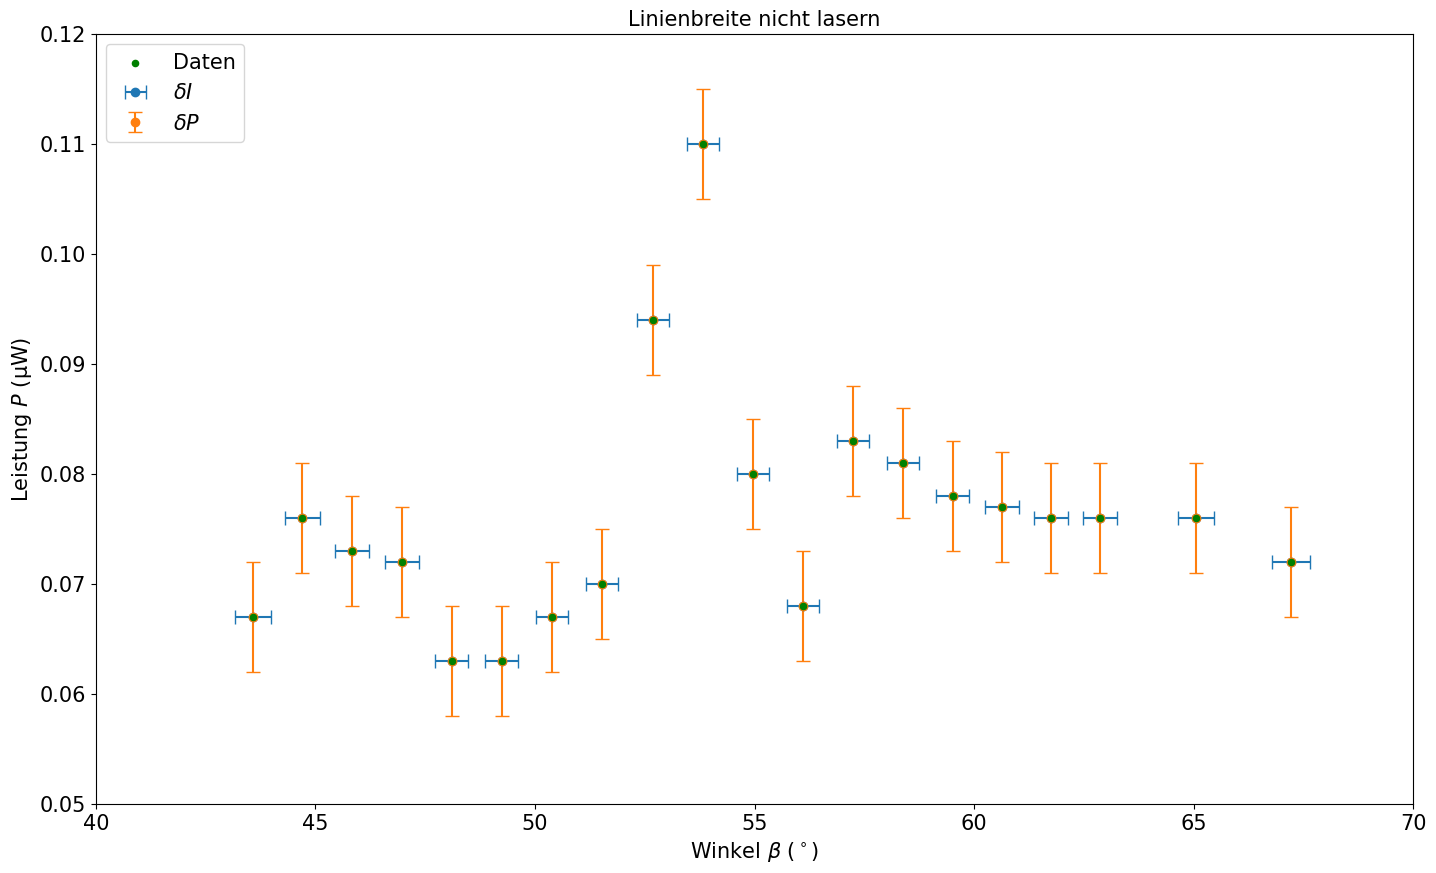

Winkel Offset: 0.50+/-0.08
Winkelmittelpunkt: 52.11+/-0.26


In [416]:
#Aufgabe 3 nicht Lasern
Mittelpunkt = ufloat(17.5, 0.2)
Laserpunkt = ufloat(16, 0.1)
Abstand = ufloat(50, 1)
Gitterabstand = 0.83e-6
Wellenlänge_Laser = 670e-9
offset_laser_spiegel = ufloat(0.13, 0.02)
abstand_Laser = ufloat (15,0.5)
Winkel_Laser = np.arcsin(Wellenlänge_Laser/Gitterabstand)*360/(2*np.pi)
Teta = unp.arctan((Mittelpunkt-Laserpunkt)/Abstand)*360/(2*np.pi)
Winkelmittelpunkt = Winkel_Laser - Teta
winkel_offset = unp.arctan(offset_laser_spiegel/abstand_Laser)*360/(2*np.pi)

new_column = np.empty((a3_1_uarray.shape[0], 1))
a3_1_uarray = np.column_stack((a3_1_uarray, new_column))
append = np.array([])
for i in range(len(a3_1_uarray)):
  a3_1_uarray[i,3] = Winkelmittelpunkt + 360/(2*np.pi)*unp.arctan((Mittelpunkt-a3_1_uarray[i,1])/(Abstand))
df = pd.DataFrame(a3_1_uarray)
# DataFrame in Excel-Datei exportieren
df.to_excel('outputA3_nichtlaser.xlsx', index=False)
plt.subplots(1,1,figsize=(17, 10));

x = [float(i[3].nominal_value) for i in a3_1_uarray]
y = [float(i[2].nominal_value) for i in a3_1_uarray]

plt.scatter(x, y, label = 'Daten', color='green', s=20, zorder= 5)

x_error = [float(i[3].std_dev) for i in a3_1_uarray]
y_error = [float(i[2].std_dev) for i in a3_1_uarray]

plt.errorbar(x, y, xerr=x_error, fmt='o', capsize=5, label = r'$δI$')
plt.errorbar(x, y, yerr=y_error, fmt='o', capsize=5, label = r'$δP$')



# Add axis labels and a title
plt.xlabel(r'Winkel $\beta$ ($^\circ$)', fontsize=15)
plt.ylabel(r'Leistung $P$ (µW)', fontsize=15)
plt.title('Linienbreite nicht lasern', fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

# Display the plot
plt.legend(loc = 'upper left', fontsize=15)
plt.axis([40, 70, 0.05, 0.12]) #Achsenanpassung
plt.show()
print('Winkel Offset:', winkel_offset)
print('Winkelmittelpunkt:', Winkelmittelpunkt)

In [417]:
#Korrektur A3_1
offset = a3_1_uarray[7,2]-a3_1_uarray[8,2]
print(offset)
a3_1_uarray[8,2] = a3_1_uarray[8,2] + offset
a3_1_uarray[9,2] = a3_1_uarray[9,2] + offset
a3_1_uarray[10,2] = a3_1_uarray[10,2] + offset
a3_1_uarray[11,2] = a3_1_uarray[11,2] + offset
a3_1_uarray[12,2] = a3_1_uarray[12,2] + offset
a3_1_uarray[13,2] = a3_1_uarray[13,2] + offset
a3_1_uarray[14,2] = a3_1_uarray[14,2] + offset
a3_1_uarray[15,2] = a3_1_uarray[15,2] + offset

0.015+/-0.007


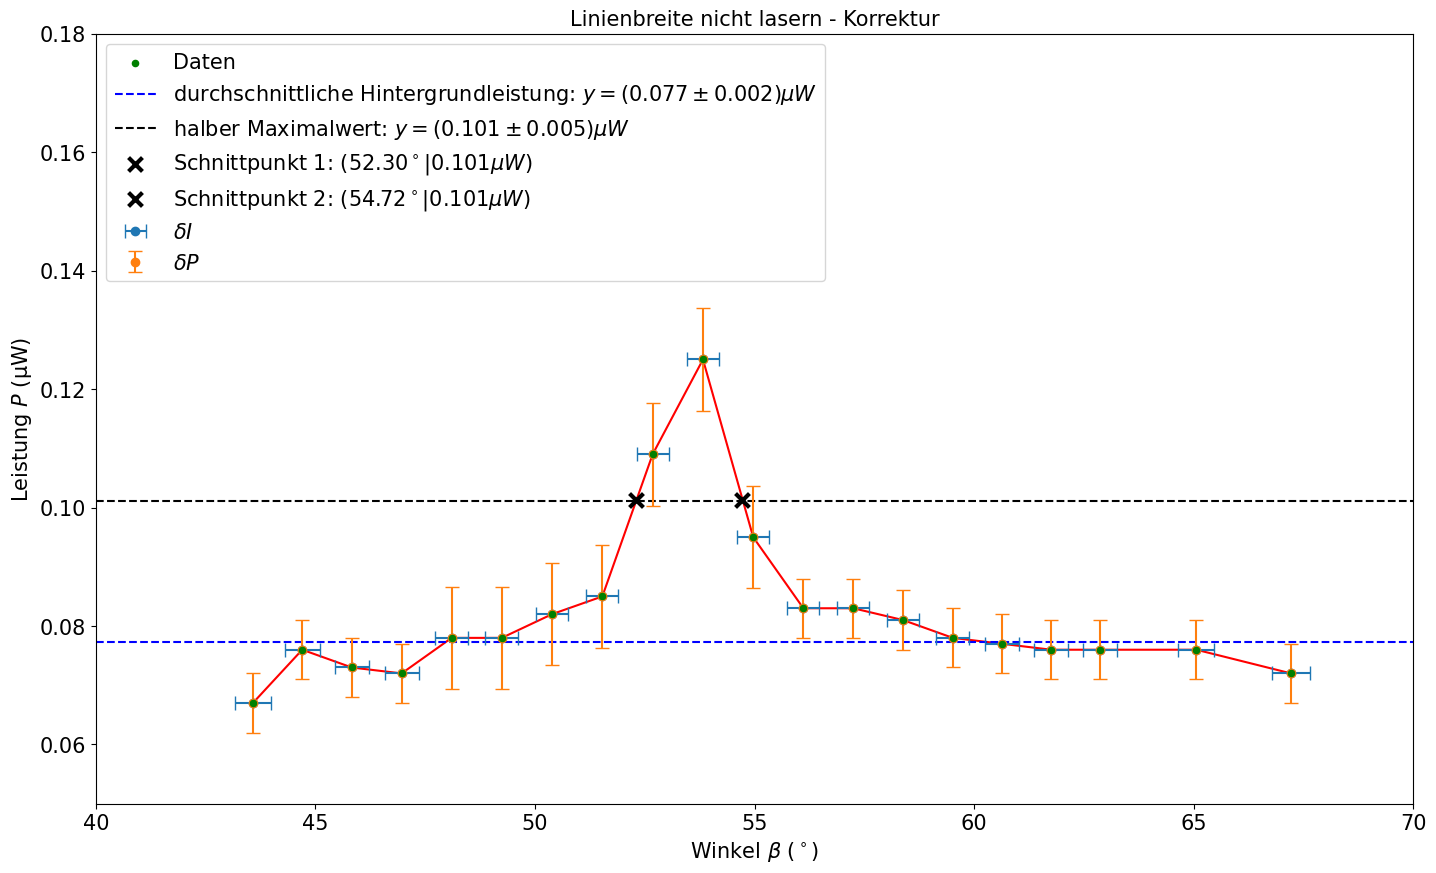

In [418]:
filtered_array = filter_array_under(a3_1_uarray, 0.09, 2)
Zero_line = np.mean(filtered_array[:,2])
d_peak_line = a3_1_uarray[10,2] - Zero_line
mittlere_höhe = d_peak_line/2
fwhm_höhe = mittlere_höhe + Zero_line

plt.subplots(1,1,figsize=(17, 10));

x = [float(i[3].nominal_value) for i in a3_1_uarray]
y = [float(i[2].nominal_value) for i in a3_1_uarray]

plt.scatter(x, y, label = 'Daten', color='green', s=20, zorder= 5)
plt.plot(x, y, color='red', linestyle='-')
plt.axhline(y=Zero_line.nominal_value, color='blue', linestyle='--', label= r'durchschnittliche Hintergrundleistung: $y = (%.3f \pm %.3f) µW$'%(Zero_line.nominal_value, Zero_line.std_dev))
plt.axhline(y=fwhm_höhe.nominal_value, color='black', linestyle='--', label= r'halber Maximalwert: $y = (%.3f \pm %.3f) µW$'%(fwhm_höhe.nominal_value, fwhm_höhe.std_dev))
plt.scatter(52.30, 0.1012, color='black', marker='x', s=100, zorder= 7, linewidth=3, label = r'Schnittpunkt 1: $(%.2f^\circ|%.3f µW)$' %(52.30, 0.1012))
plt.scatter(54.72, 0.1012, color='black', marker='x', s=100, zorder= 7, linewidth=3, label = r'Schnittpunkt 2: $(%.2f^\circ|%.3f µW)$' %(54.72, 0.1012))

x_error = [float(i[3].std_dev) for i in a3_1_uarray]
y_error = [float(i[2].std_dev) for i in a3_1_uarray]

plt.errorbar(x, y, xerr=x_error, fmt='o', capsize=5, label = r'$δI$')
plt.errorbar(x, y, yerr=y_error, fmt='o', capsize=5, label = r'$δP$')




# Add axis labels and a title
plt.xlabel(r'Winkel $\beta$ ($^\circ$)', fontsize=15)
plt.ylabel(r'Leistung $P$ (µW)', fontsize=15)
plt.title('Linienbreite nicht lasern - Korrektur', fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

# Display the plot
plt.legend(loc = 'upper left', fontsize=15)
plt.axis([40, 70, 0.05, 0.18]) #Achsenanpassung
plt.show()


In [419]:
#Aufgabe 3_1 Rechnung
I1 = ufloat(52.3, 0.6)
I2 = ufloat(54.72, 0.6)
Mittlere_breite = I2-I1
print('Mittlere Breite Peak:',Mittlere_breite)
Linienbreite = -Gitterabstand*unp.cos(a3_1_uarray[10,3])*Mittlere_breite*2*np.pi/360
print('Linienbreite:', Linienbreite)

Mittlere Breite Peak: 2.4+/-0.8
Linienbreite: (3.2+/-1.2)e-08


abstandpeak: -0.6+/-0.5 -0.6+/-0.5


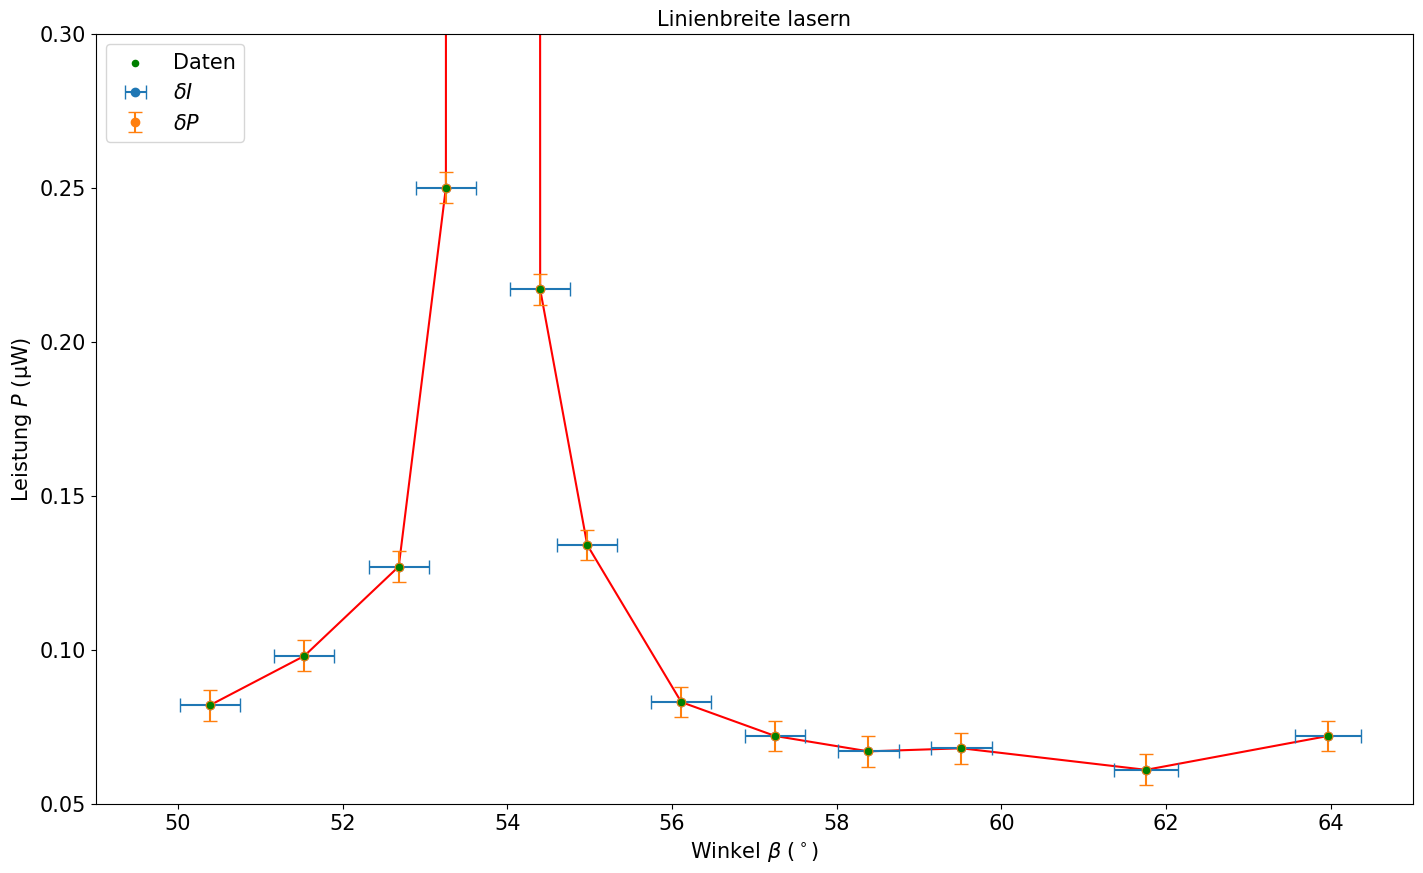

In [420]:
#Aufgabe 3 LASAAA

new_column = np.empty((a3_2_uarray.shape[0], 1))
a3_2_uarray = np.column_stack((a3_2_uarray, new_column))

append = np.array([])
for i in range(len(a3_2_uarray)):
  a3_2_uarray[i,3] = Winkelmittelpunkt + 360/(2*np.pi)*unp.arctan((Mittelpunkt-a3_2_uarray[i,1])/(Abstand))
df = pd.DataFrame(a3_2_uarray)
# DataFrame in Excel-Datei exportieren
df.to_excel('outputA3_laser.xlsx', index=False)
filtered_array = filter_array(a3_2_uarray, 0.2, 2)

d1 = filtered_array[1,3] - filtered_array[0,3] 
d2 = filtered_array[2,3] - filtered_array[1,3] 
print('abstandpeak:',d1,d2)




plt.subplots(1,1,figsize=(17, 10));

x = [float(i[3].nominal_value) for i in a3_2_uarray]
y = [float(i[2].nominal_value) for i in a3_2_uarray]

plt.scatter(x, y, label = 'Daten', color='green', s=20, zorder= 5)
plt.plot(x, y, color='red', linestyle='-')

x_error = [float(i[3].std_dev) for i in a3_2_uarray]
y_error = [float(i[2].std_dev) for i in a3_2_uarray]

plt.errorbar(x, y, xerr=x_error, fmt='o', capsize=5, label = r'$δI$')
plt.errorbar(x, y, yerr=y_error, fmt='o', capsize=5, label = r'$δP$')


# Add axis labels and a title
plt.xlabel(r'Winkel $\beta$ ($^\circ$)', fontsize=15)
plt.ylabel(r'Leistung $P$ (µW)', fontsize=15)
plt.title('Linienbreite lasern', fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

# Display the plot
plt.legend(loc = 'upper left', fontsize=15)
plt.axis([49, 65, 0.05, 0.3]) #Achsenanpassung
plt.show()


Peak: [ 53.8+/-0.4 / 65.500+/-0.005 ]
Mittlere HÖhe Peak: 32.7500+/-0.0025


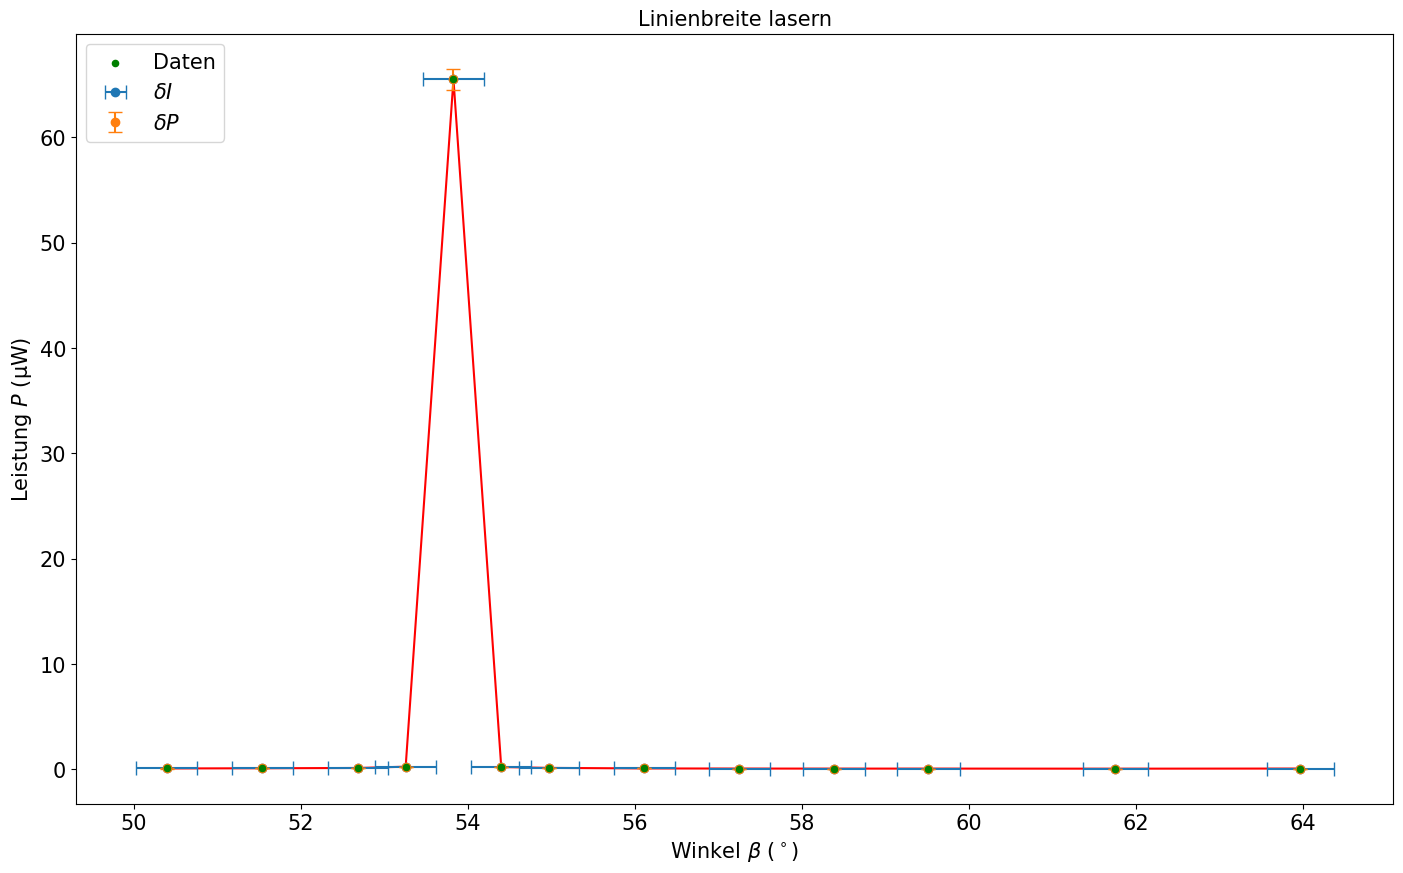

In [421]:
mittlere_peak_höhe = filtered_array[1,2]/2
print('Peak: [',filtered_array[1,3],'/',filtered_array[1,2],']')
print('Mittlere HÖhe Peak:', mittlere_peak_höhe)
filtered_array[1,2].std_dev = 1
plt.subplots(1,1,figsize=(17, 10));

x = [float(i[3].nominal_value) for i in a3_2_uarray]
y = [float(i[2].nominal_value) for i in a3_2_uarray]

plt.scatter(x, y, label = 'Daten', color='green', s=20, zorder= 5)
plt.plot(x, y, color='red', linestyle='-')

x_error = [float(i[3].std_dev) for i in a3_2_uarray]
y_error = [float(i[2].std_dev) for i in a3_2_uarray]

plt.errorbar(x, y, xerr=x_error, fmt='o', capsize=5, label = r'$δI$')
plt.errorbar(x, y, yerr=y_error, fmt='o', capsize=5, label = r'$δP$')


# Add axis labels and a title
plt.xlabel(r'Winkel $\beta$ ($^\circ$)', fontsize=15)
plt.ylabel(r'Leistung $P$ (µW)', fontsize=15)
plt.title('Linienbreite lasern', fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

# Display the plot
plt.legend(loc = 'upper left', fontsize=15)


plt.show()


In [422]:
#Aufgabe 3 Rechnung
Wellenlänge = unp.sin(filtered_array[1,3]*2*np.pi/360)*Gitterabstand
print('Wellenlänge:',Wellenlänge)


Wellenlänge: (6.700+/-0.031)e-07
